In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(f"Old working dir {os.getcwd()}")
os.chdir('../../')
print(f"New working dir {os.getcwd()}")

Old working dir /Users/vladimir.kondratyev/conditional_quantile_function/notebooks/conformal
New working dir /Users/vladimir.kondratyev/conditional_quantile_function


In [3]:
from pathlib import Path
plots_dir = Path('./conformal_plots/')
os.makedirs(plots_dir, exist_ok=True)

In [4]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
results_dir = Path('./src/conformal/conformal_results_u/')
#results_dir = Path('./conformal_results/')

In [6]:
from conformal.real_datasets.process_raw import datasets

In [7]:
# n_targets = {"rf1": 8, "rf2": 8, "scm1d": 16, "scm20d": 16, "sgemm": 4, "bio": 2, "blog": 2, ""}
n_targets = {"act": 15, 'ujiindoor':2}
df_n_targets = pd.DataFrame({"dataset_name": n_targets.keys(), "n_targets": n_targets.values()})
df_n_targets

,dataset_name,n_targets
0,act,15
1,ujiindoor,2


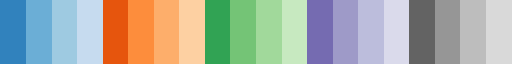

In [8]:
t20c = matplotlib.colormaps["tab20c"]
t20c

In [9]:
palette = {
    "OT-CP-Global": t20c(0),
    "OT-CP-Local": t20c(1),
    "Ell-Local": t20c(2),
    "PB": t20c(4),
    "RPB": t20c(5),
    "HPD": t20c(6),
    "Quantile": t20c(7),
    "PB (CPFlow)": t20c(8),
    "RPB (CPFlow)": t20c(9),
    "HPD (CPFlow)": t20c(10),
    "Quantile (CPFlow)": t20c(11),
    "PB (Y)": t20c(12),
    "RPB (Y)": t20c(13),
    "HPD (Y)": t20c(14),
    "Quantile (Y)": t20c(15),
}

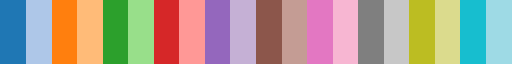

In [10]:
colormap = matplotlib.colormaps["tab20"]
colormap

In [11]:
selected_palette = {
    "OT-CP-Global": colormap(0),
    "OT-CP-Local": colormap(1),
    "PB": colormap(2),
    "RPB": colormap(3),
    "PB (RF)": colormap(4),
    "RPB (RF)": colormap(5),
    
    "PB (Y, RF)": colormap(6),
    "RPB (Y, RF)": colormap(7),

    "PB (Y)": colormap(8),
    "RPB (Y)": colormap(9),
    
    "Ell-Local": colormap(12),
}

In [12]:
# Where to load each method/metric from?


In [13]:
from typing import Literal

def load_methods_from(method_names: List[str], path: str | Path, seeds=range(10), extention: Literal["feather", "csv"] = "feather") -> pd.DataFrame:
    dataframes = []
    #seeds = range(10)
    for seed in seeds:
        for dataset_name in datasets:
            fn = Path(path) / dataset_name / str(seed) / f"metrics_all.{extention}"
            if fn.is_file():
                if extention == "feather":
                    dataframes.append(pd.read_feather(fn))
                else:
                    dataframes.append(pd.read_csv(fn))
            else:
                print(f"Error: dataset {dataset_name}, seed {seed} not found.")
    df = pd.concat(dataframes).merge(df_n_targets, on="dataset_name")
    if "volume" in df.columns:
        df["log_vol_d"] = np.log(df["volume"]) / df["n_targets"]
    if len(method_names) > 0:
        df = df[df["method_name"].isin(method_names)]
    return df


In [14]:
df0 = load_methods_from(method_names=['OT-CP-Global', 'OT-CP-Local', 'PB', 'RPB'], path="./src/conformal/conformal_results_u/")

Error: dataset rf1, seed 0 not found.
Error: dataset scm1d, seed 0 not found.
Error: dataset sgemm, seed 0 not found.
Error: dataset bio, seed 0 not found.
Error: dataset act_10x10, seed 0 not found.
Error: dataset rf1, seed 1 not found.
Error: dataset rf2, seed 1 not found.
Error: dataset sgemm, seed 1 not found.
Error: dataset bio, seed 1 not found.
Error: dataset blog, seed 1 not found.
Error: dataset act_10x10, seed 1 not found.
Error: dataset rf1, seed 2 not found.
Error: dataset rf2, seed 2 not found.
Error: dataset scm1d, seed 2 not found.
Error: dataset scm20d, seed 2 not found.
Error: dataset sgemm, seed 2 not found.
Error: dataset bio, seed 2 not found.
Error: dataset blog, seed 2 not found.
Error: dataset act_10x10, seed 2 not found.
Error: dataset rf1, seed 3 not found.
Error: dataset rf2, seed 3 not found.
Error: dataset scm1d, seed 3 not found.
Error: dataset scm20d, seed 3 not found.
Error: dataset sgemm, seed 3 not found.
Error: dataset bio, seed 3 not found.
Error: dat

In [15]:
#df.head(20)
# df1 = load_methods_from(method_names=[], path="./src/conformal/conformal_results_u/")
# df2 = load_methods_from(method_names=[], path="./conformal_results_250923/", extention="csv")

In [16]:
# df1["method_name"].unique(), df2.method_name.unique()

In [17]:
# df1

In [18]:
# df2

In [19]:
# df = pd.concat([df1, df2], ignore_index=True)
df = df0

In [20]:
#palette = blended_palette(df["base_model_name"], df["conformalizer"], paletteA="Set1", paletteB="Set2")

In [21]:
#pd.DataFrame.from_dict(palette, orient="index")

In [22]:
df.shape, df[['dataset_name', 'alpha', 'method_name', 'seed']].drop_duplicates().shape

((120, 12), (120, 4))

In [23]:
df["method_name"].unique()

array(['OT-CP-Global', 'OT-CP-Local', 'PB', 'RPB'], dtype=object)

In [24]:
df[df["dataset_name"].isin(["ujiindoor", "act"])].head()

,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,worst_slab_coverage_se,n_targets
0,ujiindoor,0,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForestWithScore,0.1,0.8990,0.885316,0.009816,2
1,ujiindoor,0,OT-CP-Local,$\mathrm{OT}$-$\mathrm{CP}$+,Signed Error,OTCPLocalPredictor,RandomForestWithScore,0.1,0.8910,0.865976,0.005827,2
3,ujiindoor,0,PB,$\mathcal{C}^{\mathrm{pb}}$,MK Rank,SplitConformalPredictor,CVQRegressor,0.1,0.9110,0.889214,0.008368,2
4,ujiindoor,0,RPB,$\mathcal{C}^{\mathrm{rpb}}$,MK Quantile,OTCPGlobalPredictor,CVQRegressor,0.1,0.9060,0.891330,0.006661,2
11,ujiindoor,0,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForestWithScore,0.2,0.8115,0.772825,0.025026,2


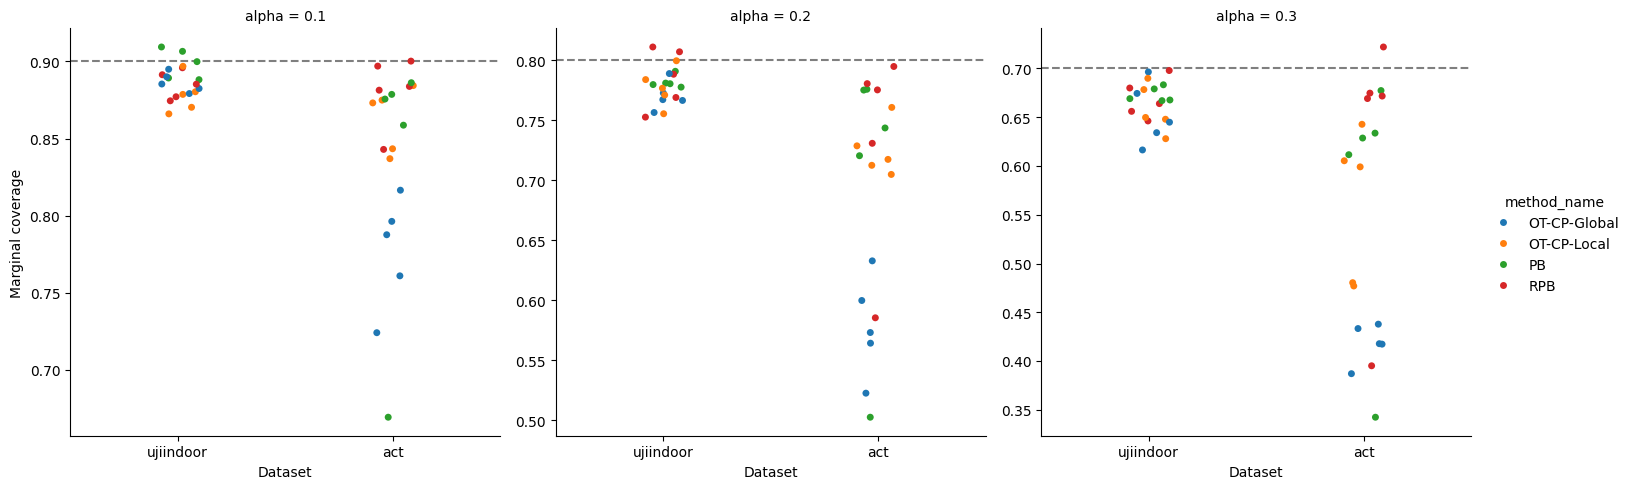

In [25]:
g_cov = sns.catplot(
    data=df[df["dataset_name"].isin(["ujiindoor", "act"])], x="dataset_name", y="worst_slab_coverage", col="alpha", hue="method_name", sharey=False,
)
g_cov.set_axis_labels("Dataset", "Marginal coverage")

for alpha, ax in g_cov.axes_dict.items():
    # ax.set_ylim(0.5, 1.)
    ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
#for ax in g_cov.axes.flatten():
#    ax.tick_params(labelbottom=True)

In [36]:
for alpha_level in [0.1, 0.2, 0.3]:
    median_df = df.copy()
    median_df = median_df[median_df["dataset_name"].isin(["act"])]
    median_df = median_df[median_df["alpha"] == alpha_level]

    # metrics you want medians for
    metrics = ["marginal_coverage", "worst_slab_coverage", "worst_slab_coverage_se"]

    # group columns = all non-metric columns EXCEPT 'seed' (since we want to aggregate across seeds)
    group_cols = [c for c in median_df.columns if c not in metrics + ["seed"]]

    median_by_dataset_method = (
        median_df.groupby(group_cols, dropna=False)[metrics]
        .median()
        .reset_index()
        .rename(columns={
            "marginal_coverage": "marginal_coverage_median",
            "worst_slab_coverage": "worst_slab_coverage_median",
            "worst_slab_coverage_se": "worst_slab_coverage_se_median",
        })
        .merge(
            median_df.groupby(group_cols)["seed"].nunique().rename("n_seeds"),
            on=group_cols,
            how="left"
        )
    )
    print(f"Requested coverage: {1 - alpha_level}")
    print(median_by_dataset_method[["method_name", "worst_slab_coverage_median"]], end="\n\n")

Requested coverage: 0.9
    method_name  worst_slab_coverage_median
0  OT-CP-Global                    0.787662
1   OT-CP-Local                    0.873076
2            PB                    0.875578
3           RPB                    0.883759

Requested coverage: 0.8
    method_name  worst_slab_coverage_median
0  OT-CP-Global                    0.573218
1   OT-CP-Local                    0.717517
2            PB                    0.743715
3           RPB                    0.775433

Requested coverage: 0.7
    method_name  worst_slab_coverage_median
0  OT-CP-Global                    0.417805
1   OT-CP-Local                    0.599057
2            PB                    0.628616
3           RPB                    0.671653



In [35]:
metrics_columns = ["marginal_coverage", "worst_slab_coverage", "volume", "log_vol_d"]
id_vars = list(df.columns.difference(metrics_columns))
df_melted = pd.melt(df, id_vars=id_vars, value_vars=metrics_columns, var_name="metric", value_name="value")

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['volume', 'log_vol_d']"

In [54]:
len(df_melted)

NameError: name 'df_melted' is not defined

In [55]:
g_all = sns.catplot(
    data=df_melted,#.query("dataset_name == 'bio' or dataset_name == 'blog'"), 
    kind="box", 
    x="dataset_name", y="value", col="alpha", row="metric", hue="method_name", #_mathtext",
    #palette=palette,
    sharey="row", showfliers=False,
)
g_all.set_axis_labels("", "")
for (metric_name, alpha), ax in g_all.axes_dict.items():
    if "coverage" in metric_name:
        ax.axhline(1 - alpha, ls="--", c="k", alpha=0.5)
    if "volume" in metric_name:
        ax.set_yscale("log")
for ax in g_all.axes.flatten():
    ax.tick_params(labelbottom=True)

NameError: name 'df_melted' is not defined

In [84]:
df_main = df[
    df["dataset_name"].isin(["ujiindoor", "sgemm", "scm20d", "bio", "blog",])
    & ~df["method_name"].str.contains("(Y)")
    & ~df["method_name"].str.contains("HPD")
    & ~df["method_name"].str.contains("CPFlow")
    & ~df["method_name"].str.contains("Quantile")
    & df['worst_slab_coverage']!=0
].copy()
def get_hatch(name):
    if "Quantile" in name:
        return "/"
    elif "PB" in name:
        return "\\"
    elif "RPB" in name:
        return "x"
    elif "HPD" in name:
        return "-"
    else:
        return None
df_main["hatch"] = df_main["method_name"].apply(get_hatch)

/var/folders/rt/72m8hlc54ms0bkqzq024nm480000gp/T/ipykernel_7113/2439730489.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  & ~df["method_name"].str.contains("(Y)")


In [85]:
boxplot_hatches = {
    -3: "",
    -2: "",
    -1: "",
    0: "//",
    1: "xx",
    2: "--",
    3: "o",
}

In [86]:
df_main["hatch"].head()

0    None
1    None
2    None
3       \
4       \
Name: hatch, dtype: object

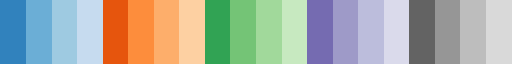

In [87]:
t20c

In [88]:
palette_appendix = {
    "OT-CP-Global": t20c(0),
    "OT-CP-Local": t20c(1),
    "Ell-Local": t20c(2),
    "PB": t20c(4),
    "RPB": t20c(5),
    "HPD": t20c(6),
    "Quantile": t20c(7),
    "PB (Y)": t20c(8),
    "RPB (Y)": t20c(9),
    "HPD (Y)": t20c(10),
    "Quantile (Y)": t20c(11),
    "PB (RF)": t20c(12),
    "RPB (RF)": t20c(13),
    "HPD (RF)": t20c(14),
    "Quantile (RF)": t20c(15),
    "PB (Y, RF)": t20c(16),
    "RPB (Y, RF)": t20c(17),
    "HPD (Y, RF)": t20c(18),
    "Quantile (Y, RF)": t20c(19),
}

In [89]:
df_main

,dataset_name,seed,method_name,method_name_mathtext,score_name,conformalizer,base_model_name,alpha,marginal_coverage,worst_slab_coverage,worst_slab_coverage_se,n_targets,hatch
0,ujiindoor,0,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForestWithScore,0.1,0.8990,0.885316,0.009816,2,None
1,ujiindoor,0,OT-CP-Local,$\mathrm{OT}$-$\mathrm{CP}$+,Signed Error,OTCPLocalPredictor,RandomForestWithScore,0.1,0.8910,0.865976,0.005827,2,None
2,ujiindoor,0,Ell-Local,$\mathrm{ELL}$-$\mathrm{local}$+,Signed Error,EllipsoidalLocal,RandomForestWithScore,0.1,0.8920,0.860208,0.008209,2,None
3,ujiindoor,0,PB,$\mathcal{C}^{\mathrm{pb}}$,MK Rank,SplitConformalPredictor,CVQRegressor,0.1,0.9110,0.889214,0.008368,2,\
4,ujiindoor,0,RPB,$\mathcal{C}^{\mathrm{rpb}}$,MK Quantile,OTCPGlobalPredictor,CVQRegressor,0.1,0.9060,0.891330,0.006661,2,\
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,ujiindoor,4,OT-CP-Global,$\mathrm{OT}$-$\mathrm{CP}$,Signed Error,OTCPGlobalPredictor,RandomForestWithScore,0.3,0.6780,0.644864,0.020442,2,None
155,ujiindoor,4,OT-CP-Local,$\mathrm{OT}$-$\mathrm{CP}$+,Signed Error,OTCPLocalPredictor,RandomForestWithScore,0.3,0.6860,0.649720,0.009882,2,None
156,ujiindoor,4,Ell-Local,$\mathrm{ELL}$-$\mathrm{local}$+,Signed Error,EllipsoidalLocal,RandomForestWithScore,0.3,0.6775,0.634369,0.011331,2,None
157,ujiindoor,4,PB,$\mathcal{C}^{\mathrm{pb}}$,MK Rank,SplitConformalPredictor,CVQRegressor,0.3,0.7000,0.666970,0.012984,2,\


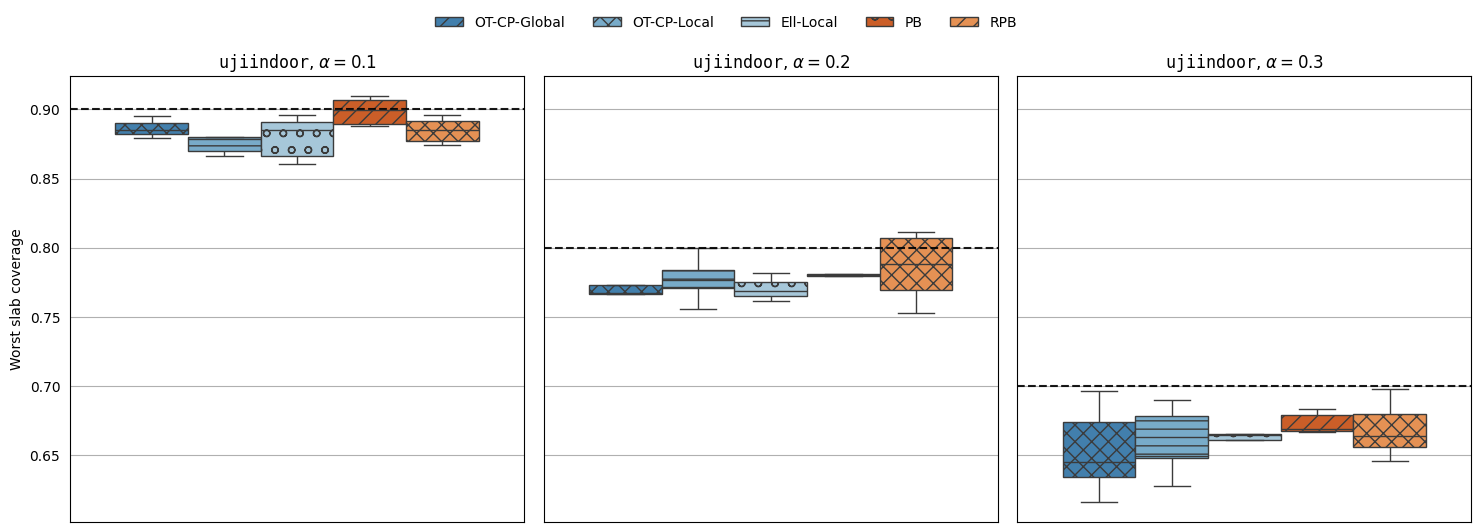

In [90]:
#n_facets_to_plot = new_ugly_filter_wsc_df["dataset_name"].nunique()
#print(n_facets_to_plot)
iclr_width = 5.50107
plot_aspect_wide = 16 / 9
plot_height = iclr_width / plot_aspect_wide
sns.set_style({'axes.grid' : True})
g_wsc = sns.catplot(
    data=df_main,
    kind="box",
    y="worst_slab_coverage",
    col="alpha",
    row="dataset_name",
    #col="dataset_name",
    hue="method_name", #_mathtext",
    palette=palette_appendix,
    sharey="row",
    showfliers=False,
    #height=plot_height,
)
g_wsc.set_axis_labels("", "Worst slab coverage")
g_wsc.set_xticklabels([])
g_wsc.despine(bottom=False, top=False, right=False)
for (dataset_name, alpha), ax in g_wsc.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
    ax.axhline(1 - alpha, xmax=1, ls="--", c="k", alpha=0.9)
for ax in g_wsc.axes.flatten():
    ax.tick_params(left=False, bottom=False)
    for i, patch in enumerate(ax.patches):
        # Blue bars first, then green bars
        patch.set_hatch(boxplot_hatches[(i - 3) % 4])
for j, legend_patch in enumerate(g_wsc.legend.get_patches()):
    legend_patch.set_hatch(boxplot_hatches[j % 4])

sns.move_legend(g_wsc, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette) // 2, title=None,
                )
g_wsc.savefig(plots_dir / "results_worst_slab_coverage_250925_hatch.pdf", bbox_inches="tight")
g_wsc.savefig(plots_dir / "results_worst_slab_coverage_250925_hatch.png", bbox_inches="tight")

# Selected results for main part

In [ ]:
df['dataset_name'].unique()

In [ ]:
#df

In [ ]:
#g_all.axes_dict
#df[df['dataset_name'] == 'sgemm']

In [ ]:
new_ugly_filter_wsc_df = df[
    (df["alpha"] == 0.1) &
    (~df["method_name"].str.contains("Quantile")) &
    ~df["method_name"].str.contains("HPD") &
    ~df["method_name"].str.contains("CPFlow") &
    ~df["dataset_name"].str.contains("rf") &
    ~df["dataset_name"].str.contains("scm1d") &
    ~df["method_name"].str.contains("Y")
].copy()
new_ugly_filter_wsc_df.columns

In [ ]:
new_ugly_filter_wsc_df['worst_slab_coverage_error'] = np.log((new_ugly_filter_wsc_df['worst_slab_coverage'] - (1 - new_ugly_filter_wsc_df['alpha'])).abs())

In [ ]:
labels_main_part_old = [r"$\mathtt{OT}$-$\mathtt{CP}$", r"$\mathtt{OT}$-$\mathtt{CP}$+", 
                        r"$\mathrm{ELL}$",
                        r"$\mathrm{PB}_{U}$", r"$\mathrm{RPB}_{U}$",
                        r"$\mathrm{PB}_{Y}$", r"$\mathrm{RPB}_{Y}$",
                        r"$\mathrm{PBS}_{U}$", r"$\mathrm{RPBS}_{U}$",
                        r"$\mathrm{PBS}_{Y}$", r"$\mathrm{RPBS}_{Y}$",]

In [ ]:
labels_main_part = [r"$\mathtt{OT}$-$\mathtt{CP}$", r"$\mathtt{OT}$-$\mathtt{CP}$+", 
                        r"$\mathrm{ELL}$",
                        r"$\mathrm{PB}$", r"$\mathrm{RPB}$",
                        r"$\mathrm{PBS}$", r"$\mathrm{RPBS}$",]

In [ ]:
n_facets_to_plot = new_ugly_filter_wsc_df["dataset_name"].nunique()
print(n_facets_to_plot)
iclr_width = 5.50107
plot_aspect_wide = 16 / 9
plot_height = iclr_width / plot_aspect_wide
sns.set_style({'axes.grid' : True})
g_wsc = sns.catplot(
    data=new_ugly_filter_wsc_df,
    kind="box",
    y="worst_slab_coverage",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    palette=selected_palette,
    sharey=True,
    showfliers=False,
    height=plot_height,
)
sns.move_legend(g_wsc, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None,
                labels=labels_main_part)
g_wsc.set_axis_labels("", "Worst slab coverage")
g_wsc.set_xticklabels([])
g_wsc.despine(bottom=False, top=False, right=False)
#for (dataset_name, alpha,), ax in g_wsc.axes_dict.items():
for dataset_name, ax in g_wsc.axes_dict.items():
    #ax.set_title(rf"$\mathtt{{{dataset_name}}}$, $\alpha={alpha:.1f}$")
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$")
    ax.axhline(1 - 0.1, xmax=1, ls="--", c="k", alpha=0.9)
for ax in g_wsc.axes.flatten():
    ax.tick_params(left=False, bottom=False)
    ax.set_ylim(0.65, 0.95)

#g_wsc.savefig(plots_dir / "selected_results_worst_slab_coverage_250924.pdf", bbox_inches="tight")
#g_wsc.savefig(plots_dir / "selected_results_worst_slab_coverage_250924.png", bbox_inches="tight")

In [ ]:
plot_height

In [ ]:
12 / 5 / 4

In [ ]:
new_ugly_filter_volume_df = df[
    (df["alpha"] == 0.1) &
    (~df["method_name"].str.contains("Quantile")) &
    ~df["method_name"].str.contains("HPD") &
    ~df["method_name"].str.contains("CPFlow") &
    #~df["dataset_name"].str.contains("scm1d") &
    #~df["dataset_name"].str.contains("rf") &
    df["dataset_name"].isin(["scm20d", "sgemm", "bio", "blog"]) &
    ~df["method_name"].str.contains("Y")    
].copy()
new_ugly_filter_volume_df.columns

In [ ]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'OT-CP-Local'")["volume"]

In [ ]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'OT-CP-Global'")["volume"]

In [ ]:
#new_ugly_filter_volume_df.query("dataset_name == 'sgemm' and method_name == 'PB'")["volume"]

In [ ]:
df_four_volumes = pd.read_csv("four_volumes.csv").set_index(["dataset_name", "seed"])
df_four_volumes

In [ ]:
df_four_volumes_rf = pd.read_csv("four_volumes_rf.csv").set_index(["dataset_name", "seed"])
df_four_volumes_rf

In [ ]:
import itertools


new_ugly_filter_volume_corrected_df = \
    new_ugly_filter_volume_df[(new_ugly_filter_volume_df["seed"].isin([0, 1, 3])) | (~new_ugly_filter_volume_df["method_name"].isin(["PB", "PB (RF)"]))].copy()
for dataset_name, seed in itertools.product(["scm20d", "sgemm", "bio", "blog"], [0, 1, 3]):
    #new_ugly_filter_volume_corrected_df["log_vol_d"] 
    new_ugly_filter_volume_corrected_df.loc[
        ((new_ugly_filter_volume_corrected_df["method_name"] == "PB")) & (new_ugly_filter_volume_corrected_df["dataset_name"] == dataset_name) & (new_ugly_filter_volume_corrected_df["seed"] == seed),
        "log_vol_d"
    ] = df_four_volumes.loc[(dataset_name, seed), "mean"]
    new_ugly_filter_volume_corrected_df.loc[
        ((new_ugly_filter_volume_corrected_df["method_name"] == "PB (RF)")) & (new_ugly_filter_volume_corrected_df["dataset_name"] == dataset_name) & (new_ugly_filter_volume_corrected_df["seed"] == seed),
        "log_vol_d"
    ] = df_four_volumes_rf.loc[(dataset_name, seed), "mean"]
new_ugly_filter_volume_corrected_df.query("method_name == 'PB (RF)'")[["dataset_name", "seed", "log_vol_d"]]

In [ ]:
g_logvold = sns.catplot(
    data=new_ugly_filter_volume_corrected_df,#.query("dataset_name == 'bio' or dataset_name == 'blog'"),
    kind="bar",
    y="log_vol_d",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    estimator="median",
    palette=selected_palette,
    sharey=False,
    #showfliers=False,
    facet_kws={
        "despine": False,
    },
    height=plot_height,
    linewidth=0.9,
    edgecolor="k",
    dodge=2.6,
    gap=0.1,
)
sns.move_legend(g_logvold, "lower center", bbox_to_anchor=(0.45, 1), ncol=len(palette), title=None, 
                labels=labels_main_part)
g_logvold.set_axis_labels("", r"$(\log V) / d$")#Worst slab coverage")
#g_logvold.set_axis_labels("", "Volume")
g_logvold.set_xticklabels([])
#g_logvold.despine(bottom=True)
for dataset_name, ax in g_logvold.axes_dict.items():
    ax.set_title(rf"$\mathtt{{{dataset_name}}}$")
for ax in g_logvold.axes.flatten():
    ax.tick_params(bottom=False)
    ax.grid(visible=True, which="both", axis="y")
    ax.set_axisbelow(True)
    #ax.set_ylim(None, 2.5)

g_logvold.savefig(plots_dir / "selected_results_volume_250925.pdf", bbox_inches="tight")
g_logvold.savefig(plots_dir / "selected_results_volume_250925.png", bbox_inches="tight")

In [ ]:
np.log(6427081) / 16

In [ ]:
new_ugly_filter_volume_df.query("method_name == 'Ell-Local'").volume.min()

In [ ]:
os.getcwd()

In [ ]:
colormap = matplotlib.colormaps["tab20"]
colormap

In [ ]:
tuned_params = {}
dfs = []
for dataset_name in ("rf1", "rf2", "scm1d", "scm20d"):
    df_tuning = pd.read_feather(f"./conformal_results_slurm/{dataset_name}/53/tuning.feather")
    print(df_tuning.loc[df_tuning['error'].idxmin()])
    tuned_params[dataset_name] = df_tuning.loc[df_tuning['error'].idxmin()].to_dict()
    df_tuning["dataset_name"] = dataset_name
    dfs.append(df_tuning)
df_tuning = pd.concat(dfs)

In [ ]:
print(tuned_params)

In [ ]:
sns.pointplot(df_tuning, x="n_epochs", y="error", hue="dataset_name")

In [ ]:
df3 = load_methods_from(method_names=[], path="./conformal_results_sgemm_no_areas/", seeds=range(10, 15), extention="feather")
df4 = load_methods_from(method_names=[], path="./conformal_results_sgemm_areas/", seeds=range(10, 15),extention="feather")

In [ ]:
df_sgemm = pd.merge(df3, df4,)

In [ ]:
df_sgemm

In [ ]:
g_sgemm_vold = sns.catplot(
    data=df_sgemm,
    kind="bar",
    y="volume",
    #col="alpha",
    #row="dataset_name",
    col="dataset_name",
    hue="method_name", #_mathtext",
    estimator="median",
    #palette=selected_palette,
    sharey=True,
    #showfliers=False,
    facet_kws={
        "despine": False,
    },
    height=plot_height,
    linewidth=0.9,
    edgecolor="k",
    dodge=2.6,
    gap=0.1,
)
plt.ylim(0, 2.5)

In [ ]:
df_sgemm.plot("volume", kind="hist")

In [ ]:
(df_sgemm["volume"] > 0).sum()